In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Exploratory Data Analysis

In [2]:
# Read the data into a data frame
data = pd.read_csv('../input/kc_house_data.csv')

In [3]:
# Check the number of data points in the data set
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types
print(data.dtypes.unique())

21613
21
[dtype('int64') dtype('O') dtype('float64')]


- Since there are Python objects in the data set, we may have some categorical features. Let's check them. 

In [4]:
data.select_dtypes(include=['O']).columns.tolist()

['date']

- We only have the date column which is a timestamp that we will ignore.

In [5]:
# Check any number of columns with NaN
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613


- The data set is pretty much structured and doesn't have any NaN values. So we can jump into finding correlations between the features and the target variable

# 2. Correlations between features and target

In [6]:
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [7]:
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [8]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


- We can see that the top 5 features are the most correlated features with the target "price"
- Let's plot the best 2 regressors jointly

In [9]:
y = data.loc[:,['sqft_living','grade',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

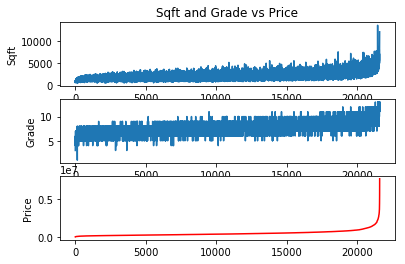

In [10]:
%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Sqft and Grade vs Price')
plt.ylabel('Sqft')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show()

# 3. Predicting House Sales Prices

In [11]:
# Train a simple linear regression model
regr = linear_model.LinearRegression()
new_data = data[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']]

In [12]:
X = new_data.values
y = data.price.values

In [13]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

In [14]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[  841418.12898114   631054.99036266   238748.92158542 ...,
  1152295.02572439   357086.73965818   451499.07818777]


In [15]:
regr.score(X_test,y_test)

0.70137060012474084

- Prediction score is about 70 which is not really optimal

In [16]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 193615.08


In [17]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [18]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [19]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.813721038305


- Our accuracy is changing between 79%-84%. I think it is close to an optimal solution.